In [1]:
from scipy.spatial import distance
from math import cos, sin
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import glob
import math
import cv2
import os

In [2]:
json_path = '/root/notebooks/0858611-2/dental/Rotate/005627 012110 p.json'
pd_json   = json.load(open(json_path, "r"))

In [3]:
def pd_dict_2_pd_dataframe(pd_json):
        table = pd.DataFrame(columns=["id", "left", "right"])

        for key in pd_json:
                front = pd_json[key]["front"]["CAL"]
                back  = pd_json[key]["back"]["CAL"]
                left  = min(front[0], back[0])
                right = min(front[2], back[2])
                table = table.append({
                        "id": key,
                        "left": left,
                        "right": right
                }, ignore_index=True)

        table.set_index("id" , inplace=True) 
        return table

def get_PD_pair(pd_table, label_name):
        
        number, side = label_name.split("_") 
        result = pd_table.loc[[number]].values[0]
        
        if side == "LR":
                return (result[0], result[1])
        elif side == "L": 
                return (result[0], -99)
        elif side == "R":
                return (-99, result[1])
        
def combination(points):
        num = len(points)
        i = 0
        while i < num:
                j = i + 1
                while j < num:
                        #print(i,j)
                        yield (i, j)           
                        j = j + 1
                i = i + 1

In [4]:
def get_rotate_degree(image, points):
    points = sorted(points ,key=lambda point:point[1])
    up_center_point   = [(points[0][0]+points[1][0])/2,(points[0][1]+points[1][1])/2]
    down_center_point = [(points[2][0]+points[3][0])/2,(points[2][1]+points[3][1])/2]
    midline = [up_center_point,down_center_point]
    midline = np.array(midline)
    midline , midline_direction = recognize_line(midline)
    midline_angle = get_line_angle(midline, midline_direction)
    
    clock = lambda x: "clockwise" if x == True else "counterclockwise"
#     print("Middle Angle: %d, %s" % (midline_angle, clock(midline_direction)) )
    return midline_angle

In [5]:
def jeff_get_rotate_degree(image,points):
    points = sorted(points ,key=lambda point:point[1])
    up_center_point   = [(points[0][0]+points[1][0])/2,(points[0][1]+points[1][1])/2]
    down_center_point = [(points[2][0]+points[3][0])/2,(points[2][1]+points[3][1])/2]
    midline = [up_center_point,down_center_point]
    midline = np.array(midline)
    #print(type(midline))
    #print(midline)
    #print(midline.shape)
    midline , midline_direction = recognize_line(midline)
    #print(type(midline))
    #print(midline)
    #print(midline.shape)
    midline_angle = get_line_angle(midline, midline_direction)
    return midline_angle

In [6]:
def get_line_angle(line, clockwise):
        vector = line[1] - line[0]
        length = np.linalg.norm(vector)
        cos    = np.dot(vector, [0, 1]) / length
        angle = math.acos(cos) *180 / math.pi
        return angle if clockwise == True else -angle

def recognize_line(line):
        sort_up_and_down = lambda line: [line[1], line[0]] if line[1][1] < line[0][1] else line
        check_clockwise  = lambda line: True if line[0][0] > line[1][0] else False    # up >>>> down
        line = sort_up_and_down(line)
        clockwise = check_clockwise(line)
        return line, clockwise

def rotate(image, angle):
    height, width = image.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)
    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]
    # rotate image with the new bounds and translated rotation matrix
    rotated_image = cv2.warpAffine(image, rotation_mat, (bound_w, bound_h))
    return rotated_image

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


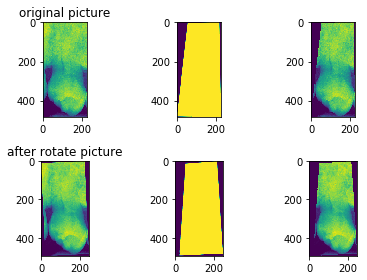

In [7]:
if __name__ == "__main__":
        
        jsons = [ i for i in glob.iglob("/root/notebooks/0858611-2/dental/Rotate/005627/*/*.json")]
        #print(jsons[-3:])
        images = [ i.replace("json", "PNG") for i in jsons]

        #pd_json   = json.load(open("Information/Tooth_info/005627 012110 p.json", "r"))
        pd_json   = json.load(open('/root/notebooks/0858611-2/dental/Rotate/005627 012110 p.json', "r"))
        pd_table = pd_dict_2_pd_dataframe(pd_json)
        mapping_dict = {}
        for data, image in zip(jsons, images):
                test_img  = cv2.imread(image, 0)
                test_data = json.load(open(data, "r"))["shapes"]
                #print('test_data',test_data)
                for tooth in test_data:
                        pd_pair = get_PD_pair(pd_table, tooth["label"])
                        points = np.array(tooth["points"]).astype(int)
                        rotate_angle = get_rotate_degree(test_img, points)
                        #rotate_angle = 0
                        #print(rotate_angle)
                        regular_point = points - points.min(axis=0)
                        
                        rect = cv2.boundingRect(points)
                        x, y, w, h = rect
                        croped = test_img[y:y+h, x:x+w].copy() 
                        ro_crop = rotate(croped, rotate_angle)

                        plt.subplot(2,3,1)
                        plt.title(label = 'original picture', loc='center')
                        plt.imshow(croped)
                        
                        mask = np.zeros(croped.shape, np.uint8)
                        cv2.drawContours(mask, [regular_point], -1, (255, 255, 255), -1, cv2.LINE_AA)
                        plt.subplot(2,3,2)
                        plt.imshow(mask)
                        
                        dst = cv2.bitwise_and(croped, croped, mask=mask)
                        plt.subplot(2,3,3)
                        plt.imshow(dst)
                        
                       
                        plt.subplot(2,3,4)
                        plt.title(label='after rotate picture', loc='center')
                        plt.imshow(ro_crop) 
                        
                        mask1 = rotate(mask, rotate_angle)
                        plt.subplot(2,3,5)
                        plt.imshow(mask1)
                        
                        dst1 = cv2.bitwise_and(ro_crop, ro_crop, mask=mask1)
                        plt.subplot(2,3,6)
                        plt.imshow(dst1)
                        plt.tight_layout()
                        
                        filename = 'result/%s' % tooth["label"]
                        if os.path.exists("%s.png" % filename) == True:
                                count = 0
                                while True:
                                        count += 1
                                        filename = filename + "%d" % count
                                        if os.path.exists("%s.png" % filename) == False:
                                                break

                        filename = filename + ".png" 
                        cv2.imwrite(filename, dst)
                        
                        mapping_dict[filename] = pd_pair

        json.dump(mapping_dict, open("005627/mapping.json", 'w'), indent=4)
        